<a href="https://colab.research.google.com/github/Onamihoang/CIFAR10_DL01/blob/master/fine_tune_CIFAR100_Submit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import InceptionResNetV2
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model,Model
from keras.datasets import cifar100
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
219062272/219055592 [==============================] - 3s 0us/step


In [3]:
conv_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [4]:
from sklearn.model_selection import train_test_split

(x_train, y_train), (x_test, y_test) = cifar100.load_data()

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

169009152/169001437 [==============================] - 6s 0us/step


[63  5 56 10 41]


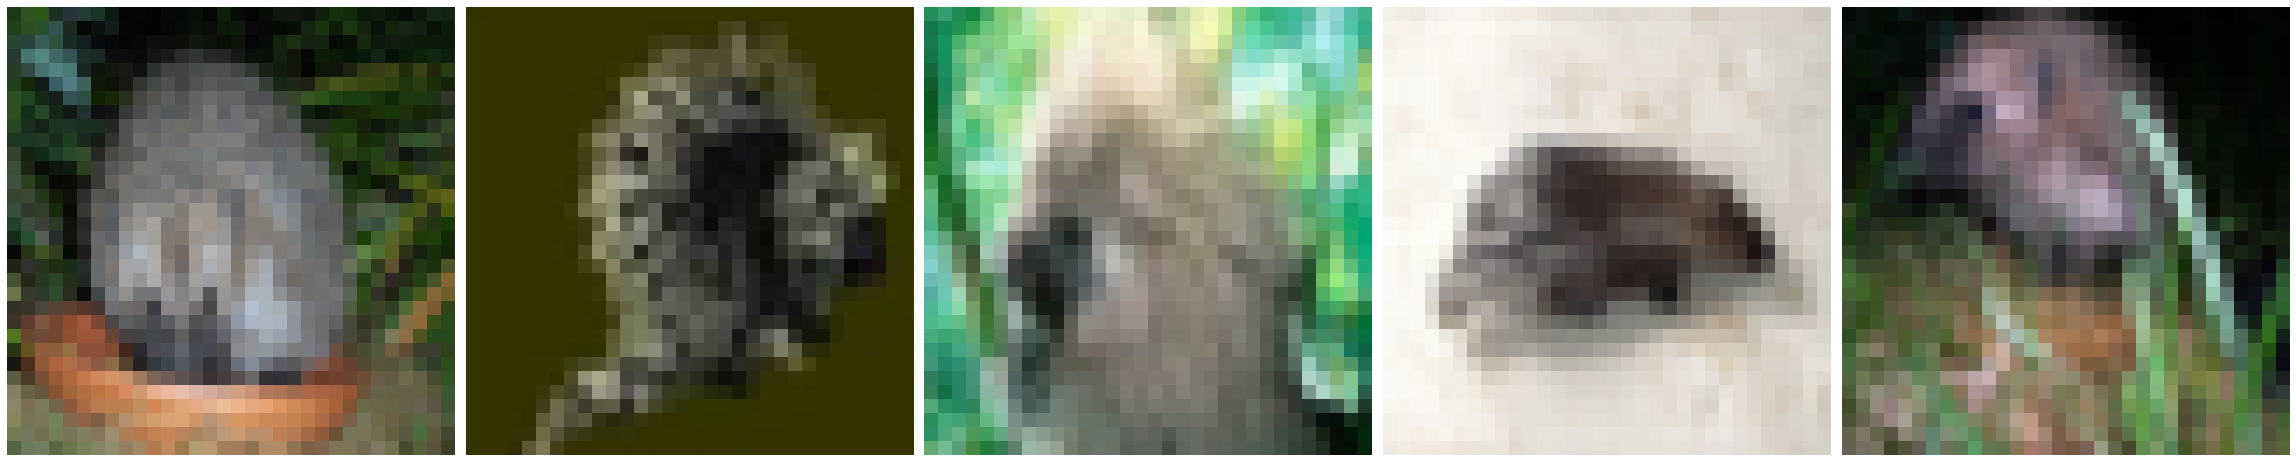

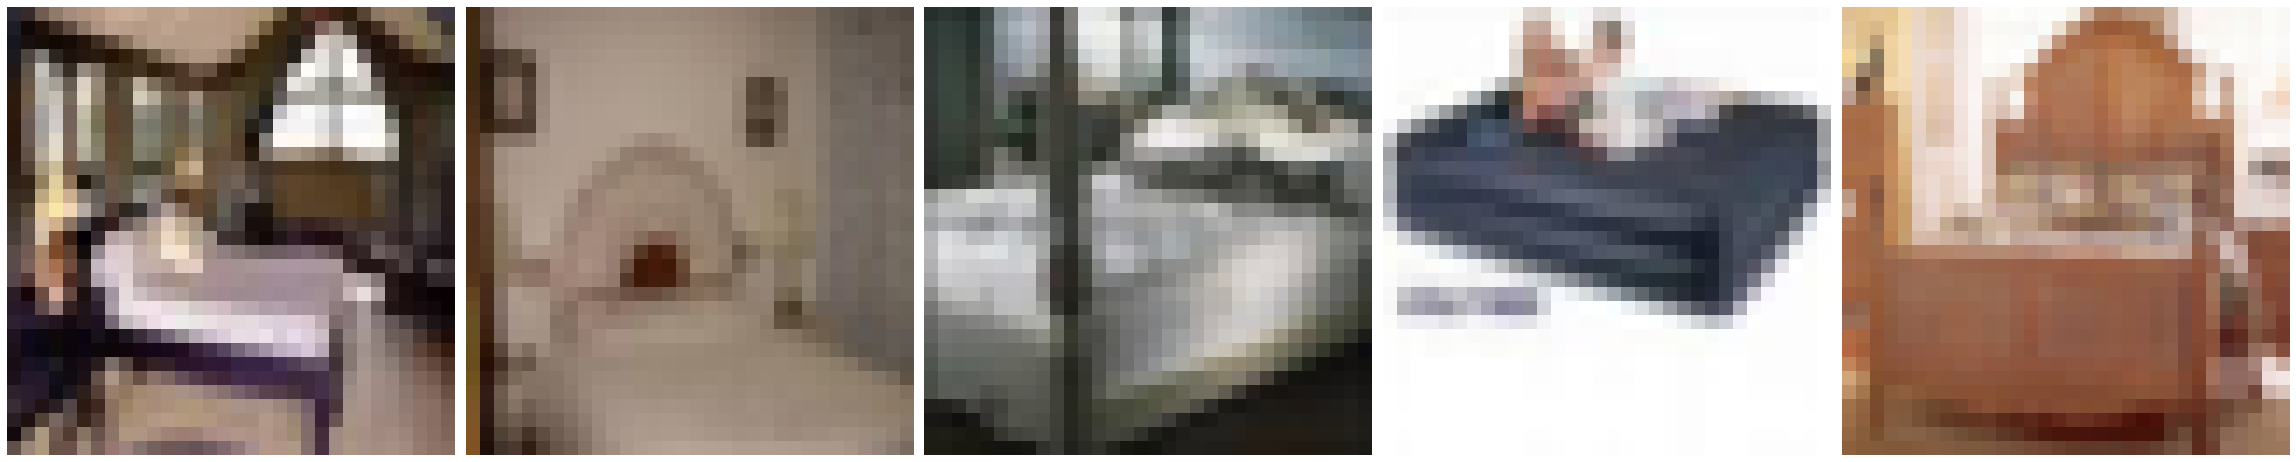

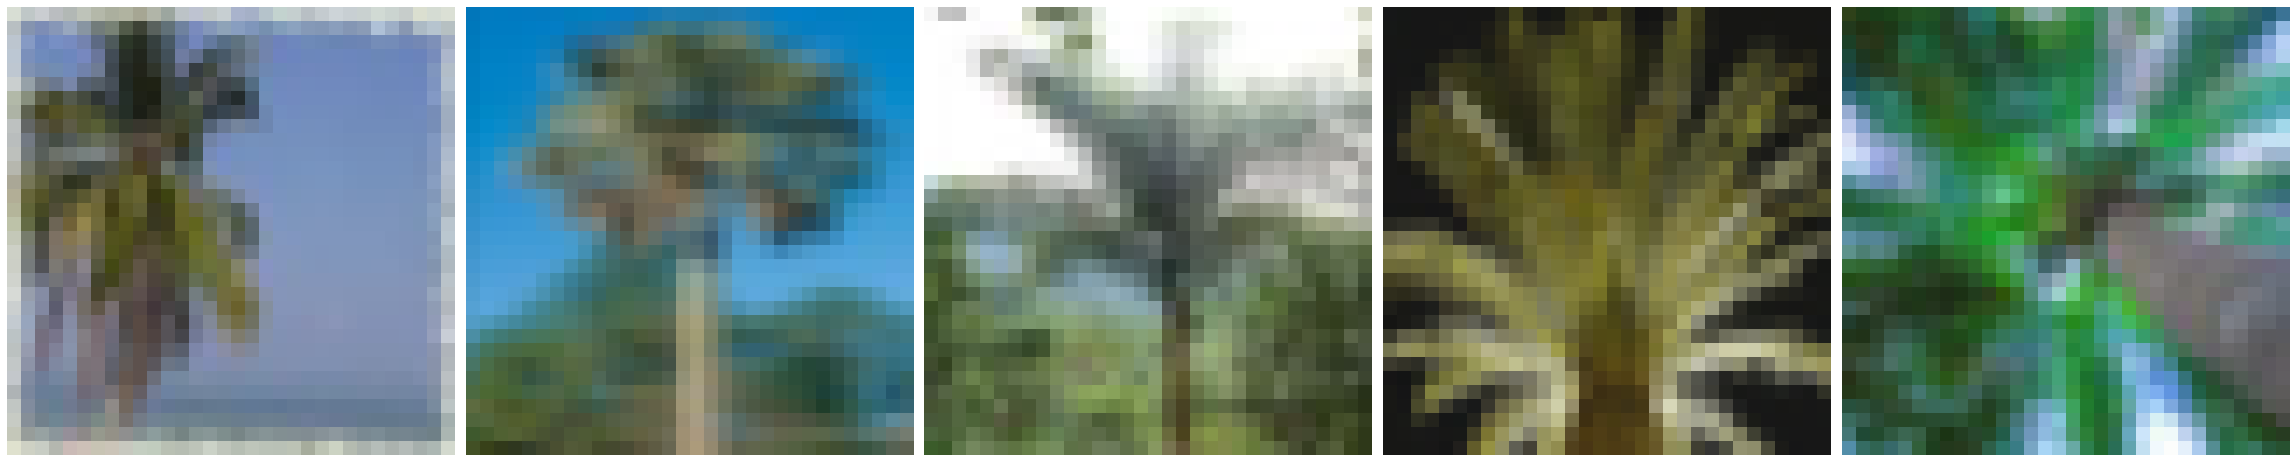

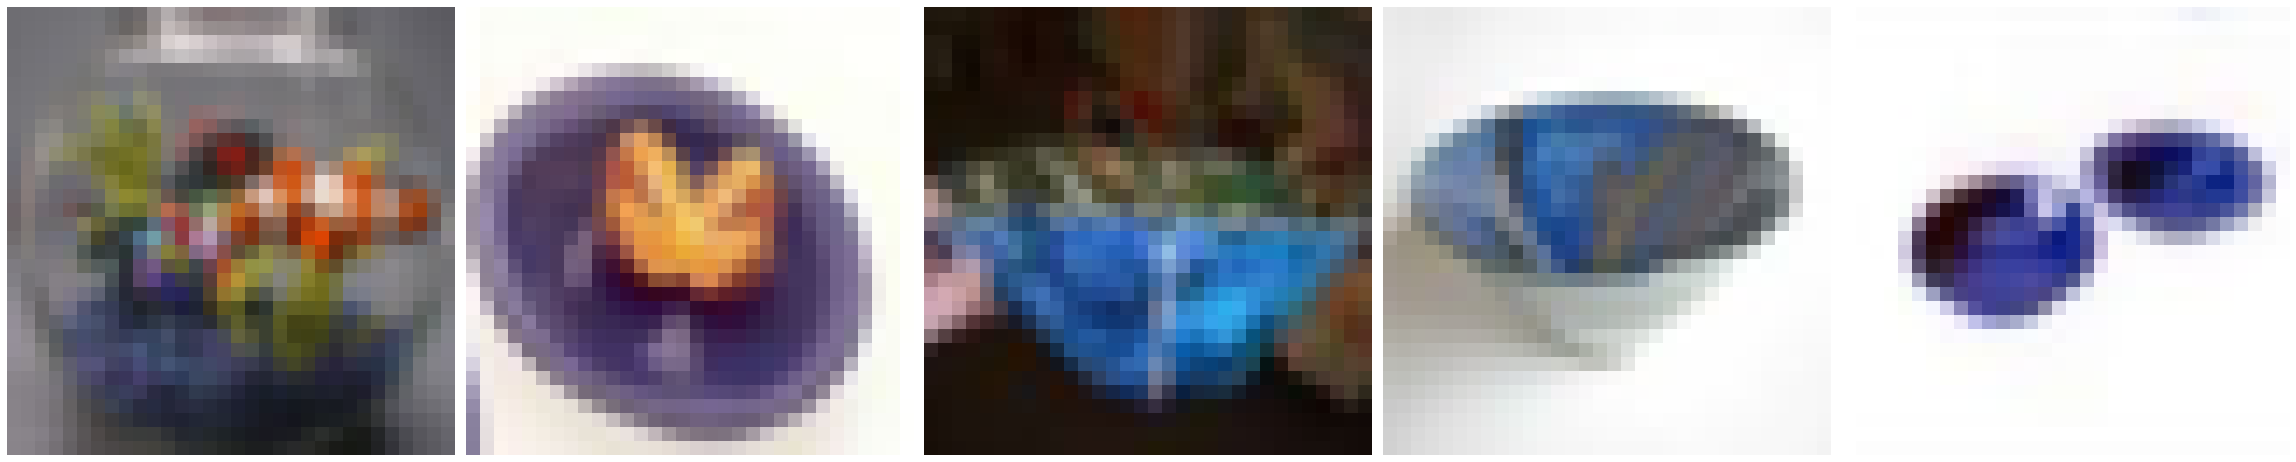

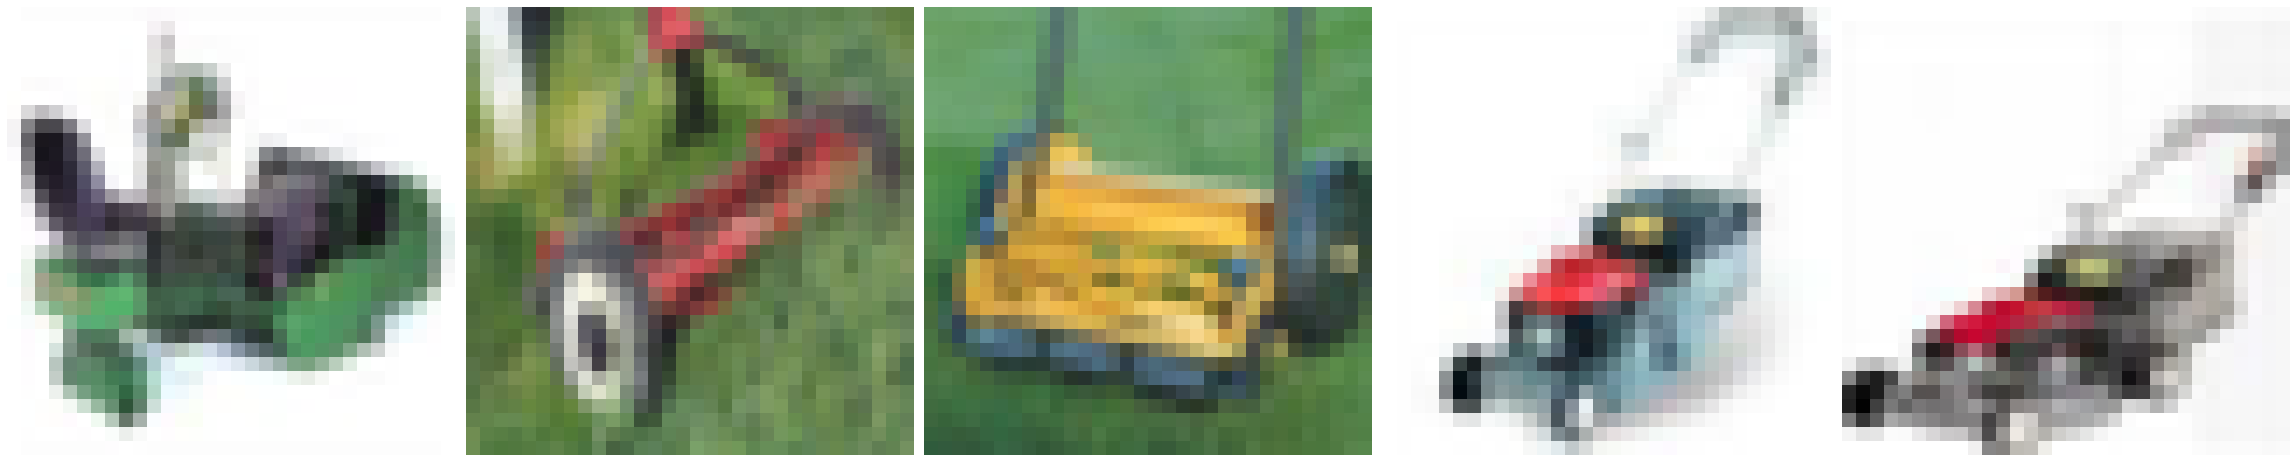

In [5]:
class_plotted = np.random.choice(range(100), 5, replace = False)
print(class_plotted)
for i in range(len(class_plotted)):
    image_samples = x_train[y_train.reshape(-1) == class_plotted[i]][:5]
    fig, ax = plt.subplots(nrows = 1, ncols = 5,figsize = (32,32))
    for j in range(5):
        ax[j].imshow(image_samples[j])
        ax[j].axis('off')  
    fig.tight_layout()
plt.show()

In [6]:
x_train = x_train / 255.0
x_val = x_val / 255
x_test = x_test / 255.0

y_train = np_utils.to_categorical(y_train, 100)
y_val = np_utils.to_categorical(y_val, 100)
y_test = np_utils.to_categorical(y_test, 100)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [0]:
model = models.Sequential()

model.add(layers.UpSampling2D((8,8),data_format=None,interpolation= 'bilinear'))

model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='elu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='elu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(100, activation='softmax'))


In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os
#es = EarlyStopping(monitor='val_acc', mode='max', min_delta=1)

filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor = 'val_acc', 
                             verbose = 1, 
                             save_best_only = True, 
                             mode = 'max')

callbacks_list = [checkpoint]
model.compile(optimizer=optimizers.Adam(learning_rate=0.00002, beta_1=0.9, beta_2=0.999, amsgrad=False),
              loss= tf.keras.losses.categorical_crossentropy, metrics=['acc'])

history = model.fit(x_train, y_train, 
                    epochs=20, batch_size=32, 
                    validation_data=(x_val, y_val),
                    callbacks = callbacks_list)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
39968/40000 [============================>.] - ETA: 0s - loss: 3.5717 - acc: 0.2601
Epoch 00001: val_acc improved from -inf to 0.66630, saving model to weights-improvement-01-0.67.h5
40000/40000 [==============================] - 678s 17ms/sample - loss: 3.5708 - acc: 0.2603 - val_loss: 1.7593 - val_acc: 0.6663
Epoch 2/20
39968/40000 [============================>.] - ETA: 0s - loss: 1.7971 - acc: 0.6776
Epoch 00002: val_acc improved from 0.66630 to 0.77860, saving model to weights-improvement-02-0.78.h5
40000/40000 [==============================] - 629s 16ms/sample - loss: 1.7968 - acc: 0.6777 - val_loss: 1.0925 - val_acc: 0.7786
Epoch 3/20
39968/40000 [============================>.] - ETA: 0s - loss: 1.1765 - acc: 0.8095
Epoch 00003: val_acc improved from 0.77860 to 0.80000, saving model to weights-improvement-03-0.80.h5
40000/40000 [==============================] - 628s 16ms/sample - loss: 1.1763 - acc: 0.8095 - val_los

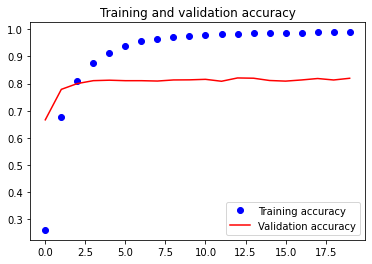

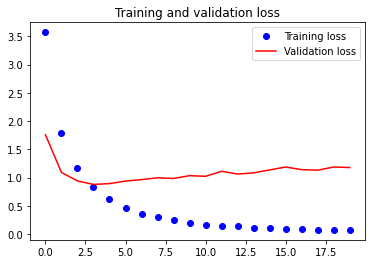

In [13]:
import matplotlib.pyplot as plt
def summarize_diagnostics(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

summarize_diagnostics(history)

In [10]:
 model.save('my_model.h5')
# del model
model = tf.keras.models.load_model('my_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 47s 5ms/sample - loss: 1.1957 - acc: 0.8145


[1.1957375064373017, 0.8145]

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d (UpSampling2D) multiple                  0         
_________________________________________________________________
inception_resnet_v2 (Model)  (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  393472    
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
batch_normalization_203 (Bat multiple                  1024      
_________________________________________________________________
dense_1 (Dense)              multiple                  3